# **1 Install and Import Dependencies**

In [ ]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
!pip install transformers requests beautifulsoup4 pandas numpy

In [59]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np

# **2. Instantiate Model**

In [60]:
#BERT model for sentiment calculation
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# **3. Encode and Calculate Sentiment**

In [61]:
tokens = tokenizer.encode('', return_tensors='pt')

In [62]:
result = model(tokens)

In [63]:
#shows sentiment score in logit form
result.logits

tensor([[-0.5486, -0.4852,  0.2038,  0.3929,  0.2652]],
       grad_fn=<AddmmBackward0>)

In [ ]:
#decodes logit back into an integer score from 1-5
int(torch.argmax(result.logits))+1

# **4. Collect Reviews**

In [65]:
#code for webscraper
r = requests.get('https://www.yelp.com/biz/the-halal-guys-orlando')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*comment.*')
results = soup.find_all('p', {'class':regex})
reviews = [result.text for result in results]

In [ ]:
reviews

# **5. Load Reviews into DataFrame and Score**

In [67]:
res = pd.DataFrame(np.array(reviews), columns= ['review'])

In [68]:
#removes comments extracted that start with 'Hi', which are typically replies from host restaurant and are not actually reviews
hostcomment = res['review'].str.startswith('Hi')
df = res[~hostcomment]

In [69]:
df

,review
0,I've been to this Hala Guys location a few tim...
2,"My family and I ordered 2 full combo platters,..."
3,"Hello Sammi S.,We are very sorry to hear you h..."
4,I moved down here from NY and was disappointed...
6,The most disappointing meal I've had in a long...
8,"To quote the fabulous Tina Turner, ""we don't n..."
10,"Im sitting in the parking lot typing this, the..."
12,Not the same as NYC. It seems the quality drop...
13,Very tasty and reasonably priced. Good portion...
15,Definitely my favorite Mediterranean fast casu...


In [70]:
#function for feeding review into sentiment analysis
def sentiment_score(review):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits))+1

In [71]:
sentiment_score(df['review'].iloc[1])

3

In [ ]:
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512]))

In [73]:
df

,review,sentiment
0,I've been to this Hala Guys location a few tim...,5
2,"My family and I ordered 2 full combo platters,...",4
3,"Hello Sammi S.,We are very sorry to hear you h...",5
4,I moved down here from NY and was disappointed...,5
6,The most disappointing meal I've had in a long...,1
8,"To quote the fabulous Tina Turner, ""we don't n...",5
10,"Im sitting in the parking lot typing this, the...",2
12,Not the same as NYC. It seems the quality drop...,2
13,Very tasty and reasonably priced. Good portion...,4
15,Definitely my favorite Mediterranean fast casu...,5


# **6. Visualization**

In [82]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

Text(0, 0.5, 'Number of Reviews')

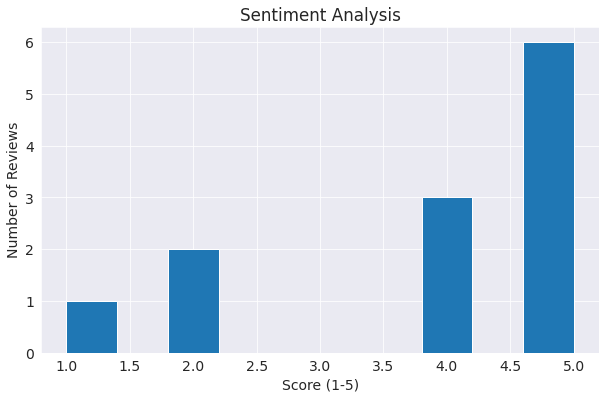

In [83]:
plt.hist(df.sentiment)
plt.title("Sentiment Analysis")
plt.xlabel('Score (1-5)')
plt.ylabel('Number of Reviews')

In [86]:
avg_score = df.sentiment.sum() / df.review.count()
avg_score

3.9166666666666665

Overall, sentiment seems to be quite positive for this particular Halal Guys. Based on reviews, the average score for this establishment is around 3.9 stars.